In [326]:
def Graficas(hist):
  plt.title = "Función de Perdidas (Entrenamiento vs Validación)"
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.xlabel('No Epocas')
  plt.legend(['Entrenamiento', 'Validación'])
  plt.show()

  plt.title = "Métricas (Entrenamiento vs Validación)"
  plt.plot(hist.history['categorical_accuracy'])
  plt.plot(hist.history['val_categorical_accuracy'])
  plt.xlabel('No Epocas')
  plt.legend(['Entrenamiento', 'Validación'])
  plt.show()

In [327]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import random

def Evaluar_Predecir(modelo, x_data, y_data, tam):
  (validation_perdidas, validation_metricas) = modelo.evaluate(x_data, y_data, batch_size = tam)
  print("Evaluación: Perdidas [{}] Métricas [{}]".format(validation_perdidas, validation_metricas))
  y_pred = modelo.predict(x_data, batch_size = tam)


  y_real = np.argmax(y_data, axis = 1)
  y_pre = np.argmax(y_pred, axis = 1)

  res = confusion_matrix(y_real, y_pre)
  plt.imshow(res, cmap = plt.cm.Blues)

  exactitud = accuracy_score(y_real, y_pre)

  print("Exactitud [{}]". format(exactitud))

  precision = precision_score(y_real, y_pre, average = 'macro')

  print("Precision [{}]". format(precision))

# Proyecto: Redes Neuronales Convolucionales


## Enunciado

En esta actividad, los alumnos deben **diseñar y evaluar varios modelos de clasificación de imagenes** empleando el **dataset asignado**. El grupo de alumnos deberá resolver el reto proponiendo una solución válida **basada en aprendizaje profundo**, más concretamente en redes neuronales convolucionales (**CNNs**). Será indispensable que la solución propuesta siga la metodologia propuesta en clases para resolver este tipo de tareas de inteligencia artificial:

1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos

5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo y planteamiento de la siguiente prueba experimental

La estrategia será una **red neuronal profunda** que los grupos **deben diseñar, entrenar y optimizar**. Se debe **justificar empíricamente** las decisiones que llevaron a la selección de la **arquitectura e hiperparámetros final**. Se espera que se utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

## Normas a seguir

- Será **indispensable** realizar el **trabajo en grupos de 3 estudiantes**.
- Se debe entregar un **ÚNICO FICHERO PDF POR GRUPO** que incluya las instrucciones presentes en el Colab Noteboook y su **EJECUCIÓN!!!**. Debe aparecer todo el proceso llevado a cabo en cada estrategia (i.e. carga de datos, inspección de datos, acondicionamiento, proceso de entrenamiento y proceso de validación del modelo).
- **La memoria del trabajo** (el fichero PDF mencionado en el punto anterior) deberá **subirla UN SOLO integrante del grupo** en la actividad que se habilitará **TEAMS**.
- Se recomienda trabajar respecto a un directorio base (**BASE_FOLDER**) para facilitar el trabajo en equipo. En este notebook se incluye un ejemplo de cómo almacenar/cargar datos utilizando un directorio base.
- Las **redes propuestas** deben estar **entrenadas** (y **EVIDENCIAR este proceso en el documento PDF**). La entrega de una **red sin entrenar** supondrá **perdida de puntos**.
- Si se desea **evidenciar alguna métrica** del proceso de entrenamiento (precisión, pérdida, etc.), estas deben ser generadas.
- Todos los **gráficos** que se deseen mostrar deberán **generarse en el Colab Notebook** para que tras la conversión aparezcan en el documento PDF.

## *Tips* para realizar la actividad con éxito
- **Generar secciones y subsecciones en el Colab Notebook** supondrá que el documento **PDF generado** queda totalmente **ordenado** facilitando la evaluación al docente.
- Se recomienda encarecidamente **incluir comentarios concisos pero aclaratorios**.
- Es muy recomendable crear una **última sección** de texto en el Colab Notebook en la que se discutan los diferentes modelos obtenidos y se extraigan las conclusiones pertinentes.

## Ejemplo de carga de datos desde un directorio

In [328]:
%pip install matplotlib
%pip install opencv-python
%pip install tensorflow
%pip install scikit-learn
%pip install keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [329]:
BASE_FOLDER = "C:/Users/Sebas/Desktop/Universidad/Taller/archive"


## Ejemplo de escritura de datos tomando como referencia un BASE_FOLDER

In [330]:
# Number of samples we will have in each class.
SAMPLE_SIZE = 319

# The images will all be resized to this size.
IMAGE_SIZE = 126

In [331]:
import shutil
import os
train_dir=BASE_FOLDER+"/train"
val_dir=BASE_FOLDER+"/val"


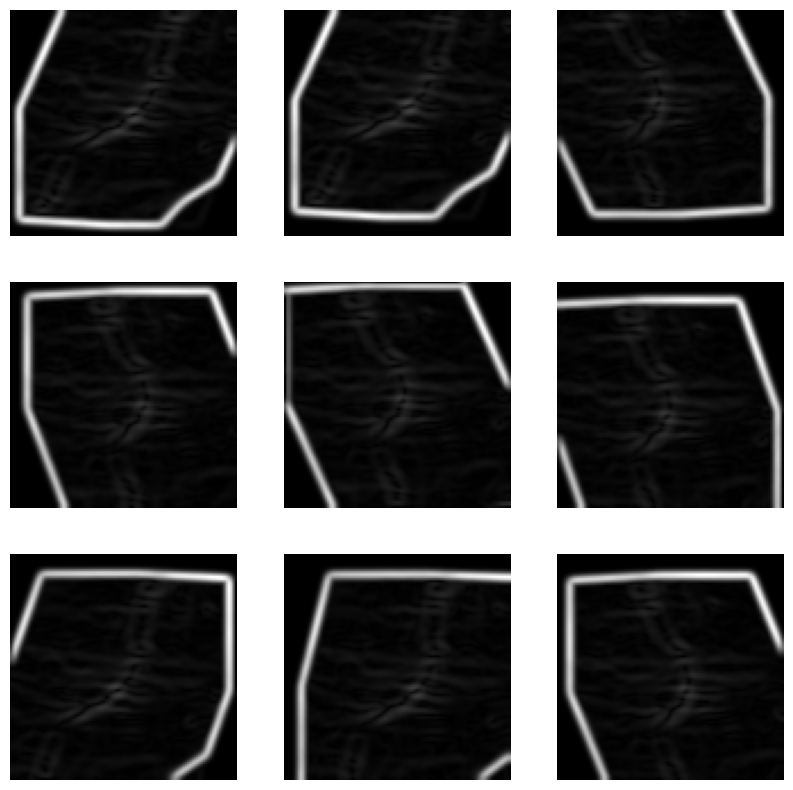

In [332]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import filters

rotation_angle = 10
shift_range = 0.1
zoom_range = 0.1
brightness_range = (0.5, 2.0)

train_dir=BASE_FOLDER+"/train"
val_dir=BASE_FOLDER+"/val"
test_dir=BASE_FOLDER+"/test"
kernel_size = 5
dim=[100,100]
x_train=[]
def augment_image(image):
    # Rotación
    angle = np.random.uniform(-rotation_angle, rotation_angle)
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))

    # Desplazamiento
    dx = np.random.uniform(-shift_range * cols, shift_range * cols)
    dy = np.random.uniform(-shift_range * rows, shift_range * rows)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    shifted_image = cv2.warpAffine(rotated_image, M, (cols, rows))

    # Zoom
    zoom_factor = 1 + np.random.uniform(-zoom_range, zoom_range)
    resized_image = cv2.resize(shifted_image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

    # Ajuste de brillo y contraste
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
    brightened_image = cv2.convertScaleAbs(resized_image, alpha=brightness_factor, beta=0)

    return brightened_image

# Iterar sobre las imágenes en el directorio de entrenamiento y aplicar aumento de datos
for i in os.listdir(train_dir):
    for j in os.listdir(os.path.join(train_dir, i)):
        image = cv2.imread(os.path.join(train_dir, i, j), cv2.IMREAD_GRAYSCALE)
        # Aplicar aumento de datos y agregar la imagen aumentada al conjunto de entrenamiento
        for _ in range(10):  # Ajusta num_augmentations_per_image según tu necesidad
            augmented_image = augment_image(image)
            resized=cv2.resize(augmented_image,(100,100),interpolation = cv2.INTER_AREA)
            imagen_suavizada = cv2.GaussianBlur(resized, (5, 5), 0)

# Paso 2: Aclarar zonas oscuras (aumentar el contraste)
# No necesitamos aplicar ecualización de histograma si ya estamos en escala de grises

# Paso 3: Aplicar el operador Sobel para detección de bordes
            sobelx = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 0, 1, ksize=5)
            gradiente_magnitud = np.sqrt(sobelx**2 + sobely**2)
            gradiente_magnitud = cv2.normalize(gradiente_magnitud, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

            x_train.append(gradiente_magnitud)
num_images = 9
plt.figure(figsize=(10, 10))  # Tamaño del gráfico

for i in range(num_images):
    plt.subplot(3, 3, i + 1)  # 3 filas, 3 columnas, posición i+1
    plt.imshow(x_train[i+10], cmap='gray')  # Mostrar imagen en escala de grises
    plt.axis('off')  # Apagar ejes

plt.show()


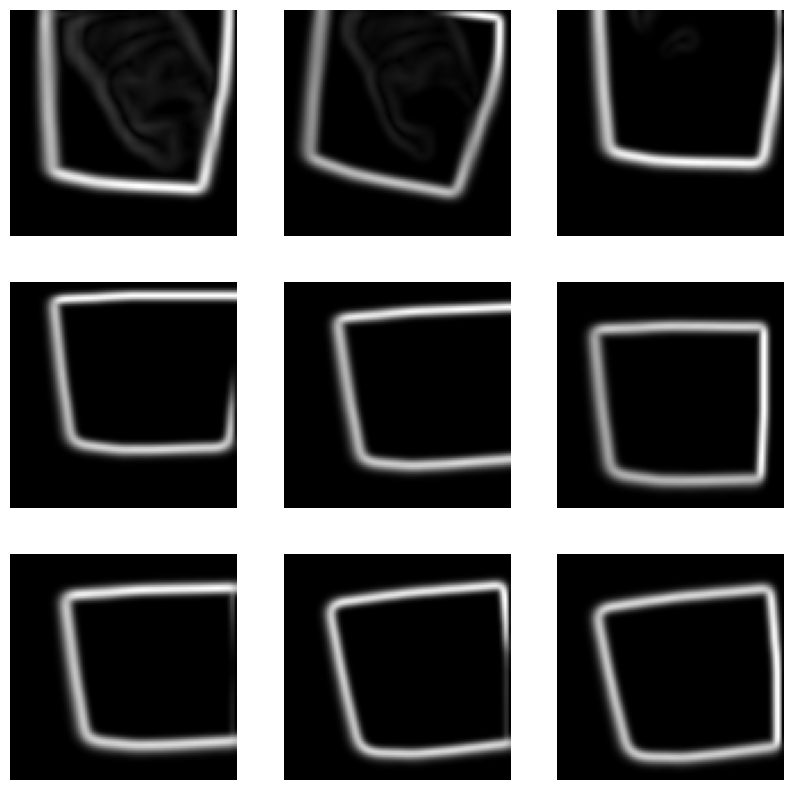

In [333]:
x_val=[]
for i in os.listdir(val_dir):
    for j in os.listdir(os.path.join(val_dir, i)):
        image = cv2.imread(os.path.join(val_dir, i, j), cv2.IMREAD_GRAYSCALE)

        # Aplicar aumento de datos y agregar la imagen aumentada al conjunto de entrenamiento
        for _ in range(10):  # Ajusta num_augmentations_per_image según tu necesidad
            augmented_image = augment_image(resized)
            resized=cv2.resize(augmented_image,(100,100),interpolation = cv2.INTER_AREA)
            imagen_suavizada = cv2.GaussianBlur(resized, (5, 5), 0)

# Paso 2: Aclarar zonas oscuras (aumentar el contraste)
# No necesitamos aplicar ecualización de histograma si ya estamos en escala de grises

# Paso 3: Aplicar el operador Sobel para detección de bordes
            sobelx = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 0, 1, ksize=5)
            gradiente_magnitud = np.sqrt(sobelx**2 + sobely**2)
            gradiente_magnitud = cv2.normalize(gradiente_magnitud, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            x_val.append(gradiente_magnitud)
num_images = 9
plt.figure(figsize=(10, 10))  # Tamaño del gráfico

for i in range(num_images):
    plt.subplot(3, 3, i + 1)  # 3 filas, 3 columnas, posición i+1
    plt.imshow(x_val[i+10], cmap='gray')  # Mostrar imagen en escala de grises
    plt.axis('off')  # Apagar ejes

In [334]:
x_test=[]
for i in os.listdir(test_dir):
    for j in os.listdir(os.path.join(test_dir, i)):
        image = cv2.imread(os.path.join(test_dir, i, j), cv2.IMREAD_GRAYSCALE)

        # Aplicar aumento de datos y agregar la imagen aumentada al conjunto de entrenamiento
        for _ in range(10):  # Ajusta num_augmentations_per_image según tu necesidad
            augmented_image = augment_image(image)
            resized=cv2.resize(augmented_image,(100,100),interpolation = cv2.INTER_AREA)
            imagen_suavizada = cv2.GaussianBlur(resized, (5, 5), 0)

# Paso 2: Aclarar zonas oscuras (aumentar el contraste)
# No necesitamos aplicar ecualización de histograma si ya estamos en escala de grises

# Paso 3: Aplicar el operador Sobel para detección de bordes
            sobelx = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 0, 1, ksize=5)
            gradiente_magnitud = np.sqrt(sobelx**2 + sobely**2)
            gradiente_magnitud = cv2.normalize(gradiente_magnitud, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            x_test.append(gradiente_magnitud)
    #print(j)

In [335]:
x_train=np.array(x_train)
x_val=np.array(x_val)
x_test=np.array(x_test)

In [336]:
print(x_train.dtype)
print(x_train.shape)

uint8
(6380, 100, 100)


In [337]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_val=x_val.astype("float32")

In [338]:
x_train = x_train/255
x_val = x_val/255
x_test=x_test/255


In [339]:
x_val[0]

array([[0.        , 0.        , 0.        , ..., 0.01176471, 0.00784314,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01176471, 0.00784314,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.01176471, 0.00784314,
        0.00784314],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.00392157,
        0.00392157],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

CREAMOS LAS CATERGORIAS

In [340]:
import tensorflow as tf
y_train = tf.keras.utils.to_categorical([0,1], 2)

y_train_new=[]
for i in y_train:
  for j in range(319*10):
    y_train_new.append(i)
y_train=np.array(y_train_new)


In [341]:
y_val = tf.keras.utils.to_categorical([0,1], 2)

y_val_new=[]
for i in y_val:
  for j in range(126*10):
    y_val_new.append(i)
y_val=np.array(y_val_new)

In [342]:
y_test = tf.keras.utils.to_categorical([0,1], 2)

y_test_new=[]
for i in y_test:
  for j in range(14*10):
    y_test_new.append(i)
y_test=np.array(y_test_new)

In [343]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D

model = Sequential()

# Extracción de características
model.add(Flatten(input_shape = (100, 100, 1), name = "Entrada"))
model.add(Dense(256, activation="relu", kernel_initializer= 'glorot_uniform', bias_initializer= 'glorot_uniform', name = "Oculta_No_1"))
model.add(Dense(128, activation="relu", name = "Oculta_No_2"))
model.add(Dense(64, activation="relu", name = "Oculta_No_3"))
model.add(Dense(32, activation="relu", name = "Oculta_No_4"))
model.add(Dense(2, activation="sigmoid", name = "Salida"))
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (Flatten)           (None, 10000)             0         
                                                                 
 Oculta_No_1 (Dense)         (None, 256)               2560256   
                                                                 
 Oculta_No_2 (Dense)         (None, 128)               32896     
                                                                 
 Oculta_No_3 (Dense)         (None, 64)                8256      
                                                                 
 Oculta_No_4 (Dense)         (None, 32)                2080      
                                                                 
 Salida (Dense)              (None, 2)                 66        
                                                                 
Total params: 2603554 (9.93 MB)
Trainable params: 260

In [344]:
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [345]:


# Print dataset sizes
print("Training data size:", len(x_train))
print("Training data size:", len(y_train))

print("Validation data size:", len(x_val))

print("Validation data size:", len(y_val))

Training data size: 6380
Training data size: 6380
Validation data size: 2520
Validation data size: 2520


In [346]:
import tensorflow as tf


callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'
callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

hist = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100


100/100 [==============================] - 4s 26ms/step - loss: 0.6998 - categorical_accuracy: 0.5516 - val_loss: 0.7087 - val_categorical_accuracy: 0.5599
Epoch 2/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6757 - categorical_accuracy: 0.5861 - val_loss: 0.7184 - val_categorical_accuracy: 0.5377
Epoch 3/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6567 - categorical_accuracy: 0.6072 - val_loss: 0.7427 - val_categorical_accuracy: 0.5361
Epoch 4/100
100/100 [==============================] - 2s 20ms/step - loss: 0.6334 - categorical_accuracy: 0.6381 - val_loss: 0.7573 - val_categorical_accuracy: 0.5286
Epoch 5/100
100/100 [==============================] - 2s 21ms/step - loss: 0.6239 - categorical_accuracy: 0.6520 - val_loss: 0.8406 - val_categorical_accuracy: 0.5298
Epoch 6/100
100/100 [==============================] - 2s 20ms/step - loss: 0.5923 - categorical_accuracy: 0.6810 - val_loss: 0.8820 - val_categorical_accuracy: 0.5238
Epoc

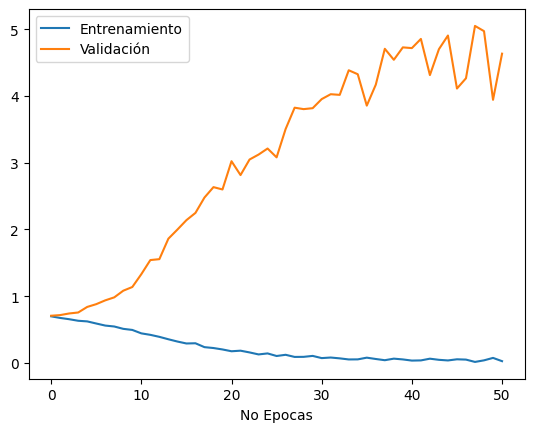

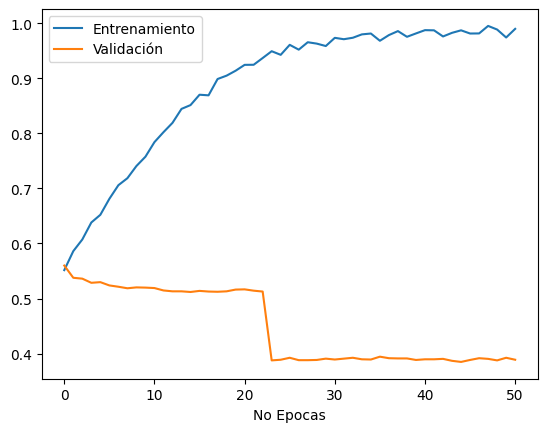

In [347]:
Graficas(hist)

5/5 [==============================] - 0s 7ms/step - loss: 3.0152 - categorical_accuracy: 0.5786
Evaluación: Perdidas [3.0152034759521484] Métricas [0.5785714387893677]
5/5 [==============================] - 0s 4ms/step
Exactitud [0.5785714285714286]
Precision [0.580950378469302]


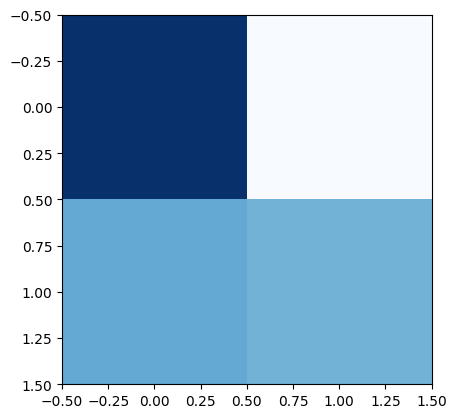

In [348]:
Evaluar_Predecir(model, x_test, y_test, 64)

MODELO 2

In [349]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout

model_conv = Sequential()

# Extracción de características
model_conv.add(Input(shape = (100, 100, 1), name = "Entrada"))

# Bloque Convolucional No 1
model_conv.add(Conv2D(filters=10, kernel_size=5, strides=(2, 2), padding='valid', activation='relu', name="Conv_No_1"))
model_conv.add(MaxPooling2D(pool_size=(4, 4), name='MaxPool_No_1'))

# Clasificación
model_conv.add(Flatten(name="Flatten"))
model_conv.add(Dense(512, activation="relu", name="Clasificacion"))
model_conv.add(Dense(2, activation="sigmoid", name="Salida"))
model_conv.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_No_1 (Conv2D)          (None, 48, 48, 10)        260       
                                                                 
 MaxPool_No_1 (MaxPooling2D  (None, 12, 12, 10)        0         
 )                                                               
                                                                 
 Flatten (Flatten)           (None, 1440)              0         
                                                                 
 Clasificacion (Dense)       (None, 512)               737792    
                                                                 
 Salida (Dense)              (None, 2)                 1026      
                                                                 
Total params: 739078 (2.82 MB)
Trainable params: 739078 (2.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [350]:
model_conv.compile(optimizer='SGD', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [351]:
callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'

callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

# hist_conv = model_conv.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

hist_conv = model_conv.fit(x_train, y_train, batch_size = 64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100
100/100 [==============================] - 3s 22ms/step - loss: 0.6929 - categorical_accuracy: 0.5071 - val_loss: 0.6987 - val_categorical_accuracy: 0.3929
Epoch 2/100
100/100 [==============================] - 2s 19ms/step - loss: 0.6913 - categorical_accuracy: 0.5329 - val_loss: 0.6986 - val_categorical_accuracy: 0.4123
Epoch 3/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6901 - categorical_accuracy: 0.5434 - val_loss: 0.6992 - val_categorical_accuracy: 0.4222
Epoch 4/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6889 - categorical_accuracy: 0.5578 - val_loss: 0.7000 - val_categorical_accuracy: 0.4294
Epoch 5/100
100/100 [==============================] - 2s 18ms/step - loss: 0.6878 - categorical_accuracy: 0.5661 - val_loss: 0.7015 - val_categorical_accuracy: 0.4167
Epoch 6/100
100/100 [==============================] - 2s 17ms/step - loss: 0.6865 - categorical_accuracy: 0.5726 - val_loss: 0.7028 - val_categorical_accuracy:

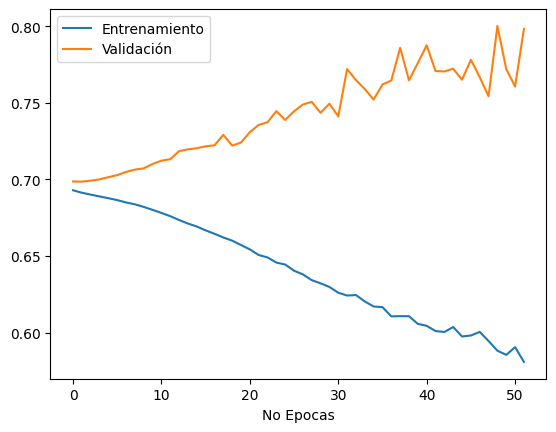

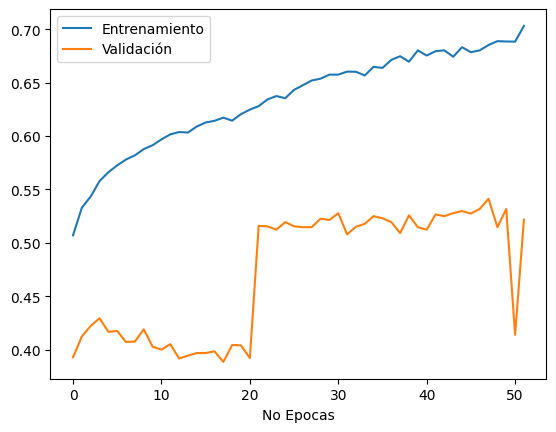

In [352]:
Graficas(hist_conv)

5/5 [==============================] - 0s 5ms/step - loss: 0.6190 - categorical_accuracy: 0.6679
Evaluación: Perdidas [0.6189632415771484] Métricas [0.6678571701049805]
5/5 [==============================] - 0s 8ms/step
Exactitud [0.6678571428571428]
Precision [0.6871977240398293]


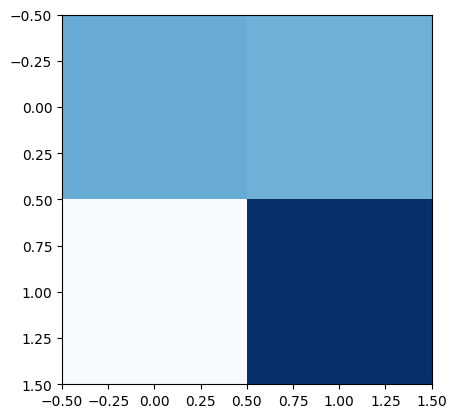

In [353]:
Evaluar_Predecir(model_conv, x_test, y_test, 64)

In [354]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout

model_conv = Sequential()

# Extracción de características
model_conv.add(Input(shape = (100, 100, 1), name = "Entrada"))

# Bloque Convolucional No 1
model_conv.add(Conv2D(filters = 20, kernel_size = 4, strides = (3,3), padding = 'valid', name = "Conv_No_1"))
model_conv.add(MaxPooling2D(pool_size = (4,4), name = 'MaxPool_No_1'))

# Clasificación
model_conv.add(Flatten(input_shape = (3,3,10), name = "Entrada_clasif"))
model_conv.add(Dense(512, activation="relu", name = "Clasificacion"))
model_conv.add(Dense(2, activation="sigmoid", name = "Salida"))
model_conv.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_No_1 (Conv2D)          (None, 33, 33, 20)        340       
                                                                 
 MaxPool_No_1 (MaxPooling2D  (None, 8, 8, 20)          0         
 )                                                               
                                                                 
 Entrada_clasif (Flatten)    (None, 1280)              0         
                                                                 
 Clasificacion (Dense)       (None, 512)               655872    
                                                                 
 Salida (Dense)              (None, 2)                 1026      
                                                                 
Total params: 657238 (2.51 MB)
Trainable params: 657238 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [355]:
model_conv.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [356]:
callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'

callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

# hist_conv = model_conv.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

hist_conv = model_conv.fit(x_train, y_train, batch_size = 64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100
100/100 [==============================] - 3s 16ms/step - loss: 0.6683 - categorical_accuracy: 0.5812 - val_loss: 0.7205 - val_categorical_accuracy: 0.4425
Epoch 2/100
100/100 [==============================] - 1s 13ms/step - loss: 0.6272 - categorical_accuracy: 0.6461 - val_loss: 0.7164 - val_categorical_accuracy: 0.4468
Epoch 3/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5997 - categorical_accuracy: 0.6707 - val_loss: 0.7549 - val_categorical_accuracy: 0.4381
Epoch 4/100
100/100 [==============================] - 1s 12ms/step - loss: 0.5700 - categorical_accuracy: 0.7009 - val_loss: 0.7763 - val_categorical_accuracy: 0.4353
Epoch 5/100
100/100 [==============================] - 1s 13ms/step - loss: 0.5379 - categorical_accuracy: 0.7252 - val_loss: 0.7913 - val_categorical_accuracy: 0.5512
Epoch 6/100
100/100 [==============================] - 1s 12ms/step - loss: 0.5071 - categorical_accuracy: 0.7420 - val_loss: 0.8278 - val_categorical_accuracy:

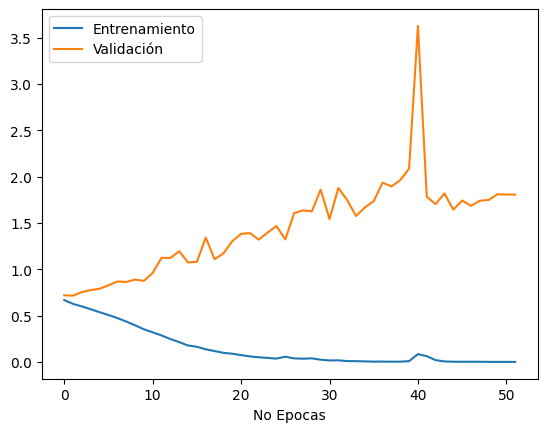

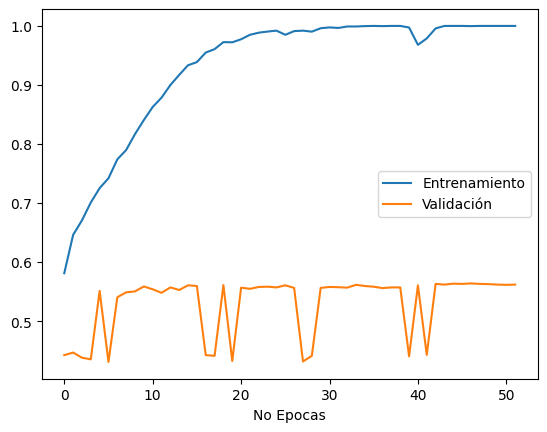

In [357]:
Graficas(hist_conv)

5/5 [==============================] - 0s 6ms/step - loss: 2.0299 - categorical_accuracy: 0.6464
Evaluación: Perdidas [2.029857873916626] Métricas [0.6464285850524902]
5/5 [==============================] - 0s 4ms/step
Exactitud [0.6464285714285715]
Precision [0.647338159043072]


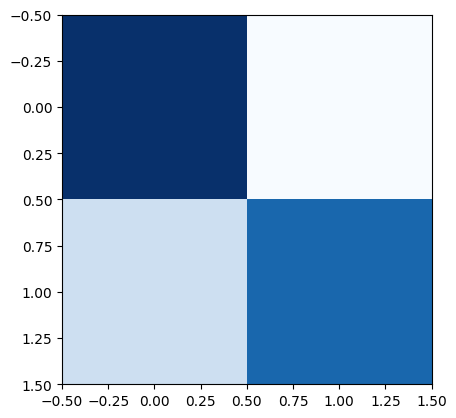

In [358]:
Evaluar_Predecir(model_conv, x_test, y_test, 64)

In [359]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Crear el modelo
model_conv = Sequential()

# Extracción de características
model_conv.add(Input(shape=(100, 100, 1), name="Entrada"))

# Bloque Convolucional No 1
model_conv.add(Conv2D(filters=20, kernel_size=4, strides=(3, 3), padding='valid', name="Conv_No_1"))
model_conv.add(MaxPooling2D(pool_size=(4, 4), name='MaxPool_No_1'))

# Bloque 2
model_conv.add(Conv2D(filters=10, kernel_size=2, strides=(2, 2), padding='valid', name="Conv_No_2"))
model_conv.add(MaxPooling2D(pool_size=(3, 3), name='MaxPool_No_2'))

# Clasificación
model_conv.add(Flatten(name="Flatten"))
model_conv.add(Dense(512, activation="relu", name="Clasificacion"))
model_conv.add(Dense(256, activation="relu", name="Clasificacion2"))
model_conv.add(Dense(128, activation="relu", name="Clasificacion3"))
model_conv.add(Dense(2, activation="sigmoid", name="Salida"))

# Mostrar resumen del modelo
model_conv.summary()


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_No_1 (Conv2D)          (None, 33, 33, 20)        340       
                                                                 
 MaxPool_No_1 (MaxPooling2D  (None, 8, 8, 20)          0         
 )                                                               
                                                                 
 Conv_No_2 (Conv2D)          (None, 4, 4, 10)          810       
                                                                 
 MaxPool_No_2 (MaxPooling2D  (None, 1, 1, 10)          0         
 )                                                               
                                                                 
 Flatten (Flatten)           (None, 10)                0         
                                                                 
 Clasificacion (Dense)       (None, 512)             

In [360]:
model_conv.compile(optimizer='RMSprop', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [361]:
callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'

callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

# hist_conv = model_conv.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

hist_conv = model_conv.fit(x_train, y_train, batch_size = 64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100
100/100 [==============================] - 3s 18ms/step - loss: 0.6928 - categorical_accuracy: 0.5092 - val_loss: 0.7067 - val_categorical_accuracy: 0.4020
Epoch 2/100
100/100 [==============================] - 1s 13ms/step - loss: 0.6902 - categorical_accuracy: 0.5329 - val_loss: 0.7369 - val_categorical_accuracy: 0.4008
Epoch 3/100
100/100 [==============================] - 2s 16ms/step - loss: 0.6874 - categorical_accuracy: 0.5455 - val_loss: 0.7275 - val_categorical_accuracy: 0.4091
Epoch 4/100
100/100 [==============================] - 1s 13ms/step - loss: 0.6862 - categorical_accuracy: 0.5472 - val_loss: 0.7505 - val_categorical_accuracy: 0.3988
Epoch 5/100
100/100 [==============================] - 1s 13ms/step - loss: 0.6837 - categorical_accuracy: 0.5547 - val_loss: 0.7535 - val_categorical_accuracy: 0.4004
Epoch 6/100
100/100 [==============================] - 1s 13ms/step - loss: 0.6817 - categorical_accuracy: 0.5639 - val_loss: 0.7335 - val_categorical_accuracy:

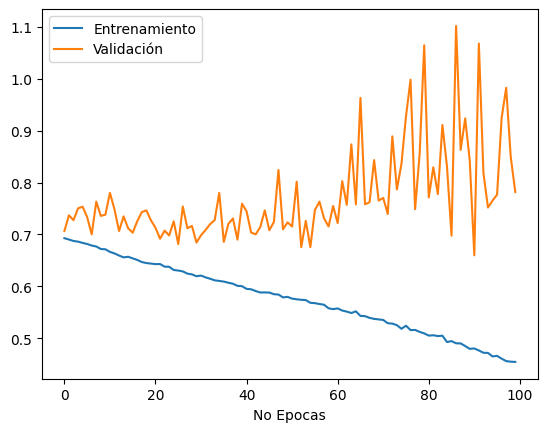

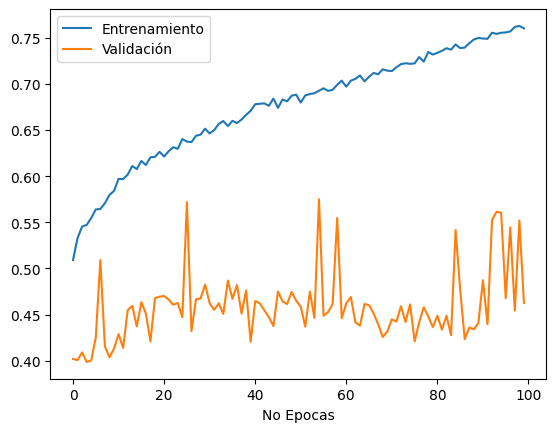

In [362]:
Graficas(hist_conv)

5/5 [==============================] - 0s 6ms/step - loss: 1.3151 - categorical_accuracy: 0.5571
Evaluación: Perdidas [1.3151029348373413] Métricas [0.5571428537368774]
5/5 [==============================] - 0s 2ms/step
Exactitud [0.5571428571428572]
Precision [0.5654970760233918]


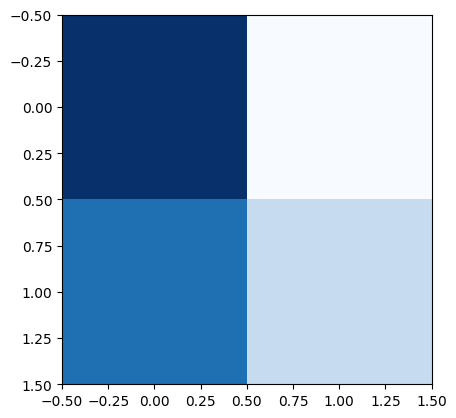

In [363]:
Evaluar_Predecir(model_conv, x_test, y_test, 64)